# **Használat előtt:**

A gyökérkönyvtárban található `kaggle.json` fájlt be kell másolni a futattás előtt, kicserélve a megfelelő helyeken a <> közötti részt a felhasználónév és API kulcs párra.

# Keretrendszerbe beépített kódrészletek

In [ ]:
!pip install opendatasets --quiet
!pip install pandas --quiet
!pip install torch --quiet
!pip install lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 53.5 MB/s eta 0:00:00


A használt keretrendszerbe beépített adatbetöltő és előfeldolgozó fájl `src/data/birds_datamodule.py` az alábbiakat tartalmazza, apróbb változtatásokkal. Az itteni változtatások az osztálynak a belső változóinak külső elérhetővé tételére szolgálnak.

In [ ]:
from typing import Any, Dict, Optional, Tuple

import torch
from lightning import LightningDataModule
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torchvision.transforms import transforms

import os
import pandas as pd
import opendatasets as od
from PIL import Image
from pathlib import Path

In [ ]:
""" Created classlist by a csv file.
:param class_csv: The class list file path.
"""
def find_class_list(class_csv: str):
    # read file
    birds_100_csv = pd.read_csv(class_csv)
    # select unique from labels list
    classes = birds_100_csv['labels'].unique()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

class ImageFolderCustom(Dataset):
    """ Costum ImageFolder. Original code from https://www.learnpytorch.io/04_pytorch_custom_datasets/.
    """

    def __init__(self, class_csv: str, targ_dir: str, transform=None) -> None:
        """ Initialize a ImageFolderCustom with a targ_dir and transform (optional) parameter.

        :param class_csv: The class list file path.
        :param targ_dir: The images directory.
        :param transform: Image transformation steps.
        """
        # Get all image paths
        self.paths = list(Path(targ_dir).glob("*/*.jpg"))
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_class_list(class_csv)

    def load_image(self, index: int) -> Image.Image:
        """ Load images by indexes from paths.

        :param index: The image path index
        """
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self) -> int:
        """ Returns the total number of samples.
        """
        return len(self.paths)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """ Returns one sample of data, data and label (X, y).
        :param index: The image path index
        """
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
          return self.transform(img), class_idx # return data, label (X, y)
        else:
          return img, class_idx # return data, label (X, y)

class BirdsDataModule(LightningDataModule):
    """`LightningDataModule` for the BIRDS 525 SPECIES- IMAGE CLASSIFICATION dataset.
    """

    def __init__(
        self,
        data_dir: str = "data/",
        train_val_test_split: Tuple[float, float, float] = (0.8, 0.1, 0.1),
        batch_size: int = 64,
        num_workers: int = 0,
        pin_memory: bool = False,
    ) -> None:
        """Initialize a `BirdsDataModule`.

        :param data_dir: The data directory. Defaults to `"data/"`.
        :param batch_size: The batch size. Defaults to `64`.
        :param num_workers: The number of workers. Defaults to `0`.
        :param pin_memory: Whether to pin memory. Defaults to `False`.
        """
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)

        # data transformations
        self.transforms = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        )

        self.data_dir = data_dir
        self.data_train: Optional[Dataset] = None
        self.data_val: Optional[Dataset] = None
        self.data_test: Optional[Dataset] = None

        self.batch_size_per_device = batch_size

    @property
    def num_classes(self) -> int:
        """Get the number of classes.

        :return: The number of Birds dataset classes.
        """
        classes, _ = find_class_list(self.data_dir+'100-bird-species/birds.csv')
        return len(classes)

    def prepare_data(self) -> None:
        """Download data if needed. Lightning ensures that `self.prepare_data()` is called only
        within a single process on CPU, so you can safely add your downloading logic within. In
        case of multi-node training, the execution of this hook depends upon
        `self.prepare_data_per_node()`.

        Do not use it to assign state (self.x = y).
        """
        if not os.path.isdir(self.data_dir+'100-bird-species/'):
            od.download(
                "https://www.kaggle.com/datasets/gpiosenka/100-bird-species", data_dir=self.data_dir)

    def setup(self, stage: Optional[str] = None) -> None:
        """Load data. Set variables: `self.data_train`, `self.data_val`, `self.data_test`.

        This method is called by Lightning before `trainer.fit()`, `trainer.validate()`, `trainer.test()`, and
        `trainer.predict()`, so be careful not to execute things like random split twice! Also, it is called after
        `self.prepare_data()` and there is a barrier in between which ensures that all the processes proceed to
        `self.setup()` once the data is prepared and available for use.

        :param stage: The stage to setup. Either `"fit"`, `"validate"`, `"test"`, or `"predict"`. Defaults to ``None``.
        """
        # Divide batch size by the number of devices.
        if self.trainer is not None:
            if self.hparams.batch_size % self.trainer.world_size != 0:
                raise RuntimeError(
                    f"Batch size ({self.hparams.batch_size}) is not divisible by the number of devices ({self.trainer.world_size})."
                )
            self.batch_size_per_device = self.hparams.batch_size // self.trainer.world_size

        # load and split datasets only if not loaded already
        if not self.data_train and not self.data_val and not self.data_test:
            image_dir_path = Path(self.data_dir + "100-bird-species/")
            birds_100_csv_path = image_dir_path / "birds.csv"
            train_dir = image_dir_path / "train"
            test_dir = image_dir_path / "test"
            val_dir = image_dir_path / "valid"
            self.trainset = ImageFolderCustom(class_csv=birds_100_csv_path, targ_dir=train_dir,transform=self.transforms)
            self.testset = ImageFolderCustom(class_csv=birds_100_csv_path, targ_dir=test_dir, transform=self.transforms)
            self.valset = ImageFolderCustom(class_csv=birds_100_csv_path, targ_dir=val_dir, transform=self.transforms)
            dataset = ConcatDataset(datasets=[self.trainset, self.testset, self.valset])
            self.data_train, self.data_val, self.data_test = random_split(
                dataset=dataset,
                lengths=self.hparams.train_val_test_split,
                generator=torch.Generator().manual_seed(42),
            )

    def train_dataloader(self) -> DataLoader[Any]:
        """Create and return the train dataloader.

        :return: The train dataloader.
        """
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.batch_size_per_device,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=True,
        )

    def val_dataloader(self) -> DataLoader[Any]:
        """Create and return the validation dataloader.

        :return: The validation dataloader.
        """
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.batch_size_per_device,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def test_dataloader(self) -> DataLoader[Any]:
        """Create and return the test dataloader.

        :return: The test dataloader.
        """
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.batch_size_per_device,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def teardown(self, stage: Optional[str] = None) -> None:
        """Lightning hook for cleaning up after `trainer.fit()`, `trainer.validate()`,
        `trainer.test()`, and `trainer.predict()`.

        :param stage: The stage being torn down. Either `"fit"`, `"validate"`, `"test"`, or `"predict"`.
            Defaults to ``None``.
        """
        pass

    def state_dict(self) -> Dict[Any, Any]:
        """Called when saving a checkpoint. Implement to generate and save the datamodule state.

        :return: A dictionary containing the datamodule state that you want to save.
        """
        return {}

    def load_state_dict(self, state_dict: Dict[str, Any]) -> None:
        """Called when loading a checkpoint. Implement to reload datamodule state given datamodule
        `state_dict()`.

        :param state_dict: The datamodule state returned by `self.state_dict()`.
        """
        pass

# Teszt futattás
Az osztály meghívása, és a megfelelő metódusok futattása. A keretrendszer szintén ebben a sorrenben végzi el a futtatásokat.

In [ ]:
module = BirdsDataModule(data_dir = "data/",
                        batch_size= 64,
                        train_val_test_split= [0.8, 0.1, 0.1],
                        num_workers= 0,
                        pin_memory= False)
module.prepare_data() #szükséges a .json fájl tartalma, vagy a futatás során bekéri a felhasználónév + API kulcs párt
module.setup()

# Adatkészlet bemutatása

A train, test és validációs adatkészletek létrehozása példaként.

In [ ]:
trainDL = module.train_dataloader()
valDL = module.val_dataloader()
testDL = module.test_dataloader()
trainDL, valDL, testDL

(<torch.utils.data.dataloader.DataLoader at 0x7d844fa1fee0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d844fa1fe80>)

In [ ]:
len(trainDL), len(valDL), len(testDL)

(1124, 141, 141)

In [ ]:
class_dict = module.trainset.class_to_idx # cimke név - azonosító pár
class_names = module.trainset.classes     # cimke név lista

**Különböző képek teszt adatai**

Az adatkészletben 80000-nél több kép van, ebből párat megadtunk előre, de másikakat is lehetséges megtekinteni, létrehozva a változót az alábbi minták szerint.

In [ ]:
data0 = [module.trainset[729][0], module.trainset[729][1]]
data1 = [module.trainset[3000][0], module.trainset[3000][1]]
data2 = [module.trainset[3700][0], module.trainset[3700][1]]
data3 = [module.trainset[15967][0], module.trainset[15967][1]]
data4 = [module.trainset[40729][0], module.trainset[40729][1]]
data5 = [module.trainset[1567][0], module.trainset[1567][1]]
data6 = [module.trainset[0][0], module.trainset[0][1]]

In [ ]:
# A general_image érétkét kell a kívántaknak megfelleően megadni. Kiválaszthatók a fentebbi adatok vagy [Kép Tensor, felirat szám] formátumban is megadható.
general_image = data0
img, label = general_image[0], general_image[1]

In [ ]:
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label id: {label}")
print(f"Image label: {class_names[label]}")
print(f"Label datatype: {type(label)}")

Image shape: torch.Size([3, 224, 224])
Image datatype: torch.float32
Image label id: 406
Image label: RED SHOULDERED HAWK
Label datatype: <class 'int'>


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def display_images(image_data: list):

    plt.figure(figsize=(5, 3))
    targ_image, targ_label = image_data[0], image_data[1]
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    title = f"class: {class_names[targ_label]}"
    plt.title(title)

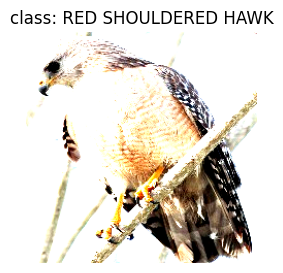

In [ ]:
display_images(general_image)